In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

22/08/25 15:58:24 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 172.26.239.248 instead (on interface eth0)
22/08/25 15:58:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/25 15:58:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/25 15:58:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/25 15:58:27 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

In [11]:
PREFIX = "main/tpcc"
IGNORE_CACHE = False

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(spark, PREFIX)\
        .withColumn("sample", col("sample").cast(T.IntegerType()))\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

index_df

Saved to: main/tpcc/index.parquet


,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,1000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,150,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,200,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,250,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,350,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,400,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,450,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,600,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,700,0,10,tpcc,0,45:43:4:4:4,1,2,-1


# Throughput

In [12]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=20
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_df),
    ignore_cache=IGNORE_CACHE,
)

throughput_df

file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients100 3154.4449260391166
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients1000 33545.17233229508
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients150 5039.3840491421
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients200 9056.47377679608
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients250 11596.350164178872
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients350 16270.173455918793
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients400 18598.895273350045
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients450 20988.782609039146
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients600 27732.586256219165
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients700 31807.79744889731
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients800 32400.16326800773
file:/home/ctring/data/detock/main/tpcc/calvin_paxos-clients900 33351.66211907428
file:/home/c

,prefix,throughput,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:/home/ctring/data/detock/main/tpcc/calvin...,3154.444926,1.0.1061,calvin_paxos.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:/home/ctring/data/detock/main/tpcc/calvin...,33545.172332,1.0.1061,calvin_paxos.conf,30,0,1000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:/home/ctring/data/detock/main/tpcc/calvin...,5039.384049,1.0.1061,calvin_paxos.conf,30,0,150,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:/home/ctring/data/detock/main/tpcc/calvin...,9056.473777,1.0.1061,calvin_paxos.conf,30,0,200,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:/home/ctring/data/detock/main/tpcc/calvin...,11596.350164,1.0.1061,calvin_paxos.conf,30,0,250,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:/home/ctring/data/detock/main/tpcc/calvin...,16270.173456,1.0.1061,calvin_paxos.conf,30,0,350,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:/home/ctring/data/detock/main/tpcc/calvin...,18598.895273,1.0.1061,calvin_paxos.conf,30,0,400,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:/home/ctring/data/detock/main/tpcc/calvin...,20988.782609,1.0.1061,calvin_paxos.conf,30,0,450,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:/home/ctring/data/detock/main/tpcc/calvin...,27732.586256,1.0.1061,calvin_paxos.conf,30,0,600,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:/home/ctring/data/detock/main/tpcc/calvin...,31807.797449,1.0.1061,calvin_paxos.conf,30,0,700,0,10,tpcc,0,45:43:4:4:4,1,2,-1


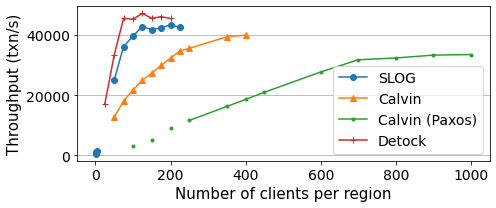

In [13]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = "clients"
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index()
pivoted["clients"] = pivoted.index
pivoted.rename(columns={
    "baseline.conf": "SLOG",
    "ddr_ts.conf": "Detock",
    "calvin.conf": "Calvin",
    "calvin_paxos.conf": "Calvin (Paxos)",
}, inplace=True)
pivoted.columns.name = ''

ax = pivoted.plot(x="clients", xlabel="Number of clients per region", ylabel='Throughput (txn/s)', rot=0, legend=False, figsize=(7,3))

markers = ["o", "^", ".", "+"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

ax.legend(ax.get_lines(), pivoted.columns)

plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/tpcc-throughput.pdf')

# Latency

# By regions

In [7]:
index_sdf = get_index(spark, PREFIX)

latency_sdf = latency(spark, map(
        lambda r : r.prefix,
        index_sdf.select("prefix").collect()
    ))\
    .join(index_sdf, on="prefix")\
    .withColumn(
        "coordinator_region",
        F.when(F.col("config_name") == "calvin.conf", F.shiftright(col("coordinator"), 16))\
            .when(F.col("config_name") == "calvin_paxos.conf", F.shiftright(col("coordinator"), 16))\
            .when(F.col("config_name") == "baseline.conf", F.shiftright(col("coordinator"), 24))\
            .otherwise(F.col("coordinator") / 4)\
        .cast(T.IntegerType())
    )\
    .orderBy("clients")\
    .cache()

In [8]:
def plot_latency_per_region(sdf_dict, order, cycle):
    rows = 2
    cols = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 6), sharex=True)
    regions = [
        "us-east-2",
        "us-east-1",
        "eu-west-1",
        "eu-west-2",
        "ap-northeast-1",
        "ap-northeast-2",
        "ap-southeast-1",
        "ap-southeast-2"
    ]
    for i in range(8):
        r, c = i // cols, i % cols
        ax[r, c].set_prop_cycle(cycle)
        for label in order:
            sdf = sdf_dict[label]
            plot_cdf(
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                ax=ax[r, c],
                label=label if i == 0 else '_nolegend_',
            )

        ax[r, c].set_title(f"{regions[i]}")
        if r == rows - 1:
            ax[r, c].set_xlabel("latency (ms)")

    return fig, ax


22/08/25 16:00:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients75/client/4/transactions.csv
22/08/25 16:00:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients75/client/3/transactions.csv
22/08/25 16:00:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file:

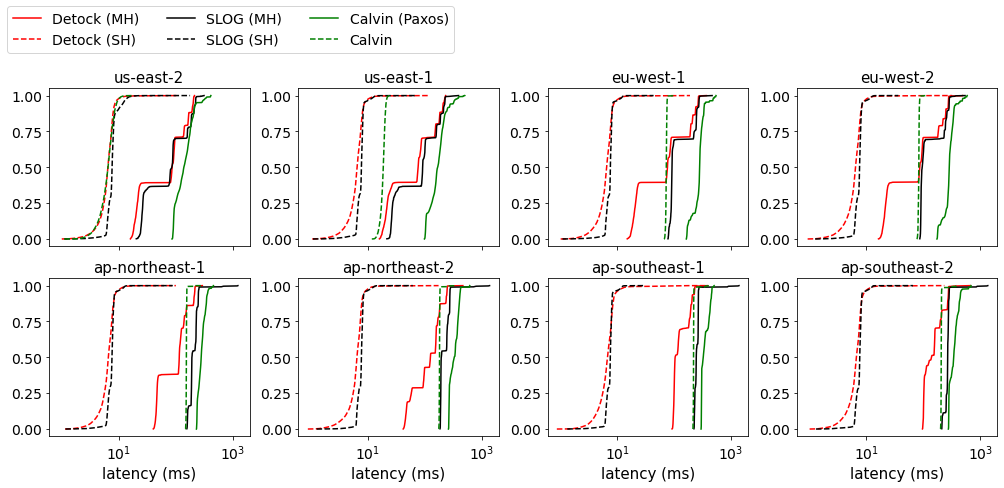

In [9]:
baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & (col("clients") == 2)).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & (col("clients") == 25)).cache()
calvin_sdf = latency_sdf.where((col("config_name") == "calvin.conf") & (col("clients") == 50)).cache()
calvin_paxos_sdf = latency_sdf.where((col("config_name") == "calvin_paxos.conf") & (col("clients") == 100)).cache()

MH_FILTER = F.size("regions") > 1
SH_FILTER = F.size("regions") == 1

fig, _ = plot_latency_per_region({
        "Detock (MH)": ddr_ts_sdf.where(MH_FILTER),
        "Detock (SH)": ddr_ts_sdf.where(SH_FILTER),
        "SLOG (MH)": baseline_sdf.where(MH_FILTER),
        "SLOG (SH)": baseline_sdf.where(SH_FILTER),
        "Calvin (Paxos)": calvin_paxos_sdf,
        "Calvin": calvin_sdf,
    },
    [
        "Detock (MH)",
        "Detock (SH)",
        "SLOG (MH)",
        "SLOG (SH)",
        "Calvin (Paxos)",
        "Calvin"
    ],
    cycler(color='rkg') * cycler(linestyle=['-', '--']),
)

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=3)
fig.tight_layout()
fig.savefig('output/tpcc-cdf.pdf', bbox_inches='tight')
fig.savefig('output/tpcc-cdf.png', bbox_inches='tight')

# Throughput & Latency

In [14]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.90).alias("percentile_90"),
    F.percentile_approx("latency", 0.95).alias("percentile_95"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

baseline_pct = from_cache_or_compute(
    f'{PREFIX}/baseline_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "baseline.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

ddr_ts_pct = from_cache_or_compute(
    f'{PREFIX}/ddr_ts_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "ddr_ts.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

calvin_pct = from_cache_or_compute(
    f'{PREFIX}/calvin_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "calvin.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

latency_pct_df = pd.concat([
    baseline_pct.assign(config_name="baseline.conf"),
    ddr_ts_pct.assign(config_name="ddr_ts.conf"),
    calvin_pct.assign(config_name="calvin.conf"),
])

throughput_latency_df = throughput_df[["config_name", "clients", "throughput"]].merge(
    latency_pct_df,
    on=["config_name", "clients"]
).sort_values("clients")
throughput_latency_df.sort_values(["config_name", "throughput"])

Saved to: main/tpcc/baseline_latency_pct.parquet


Saved to: main/tpcc/ddr_ts_latency_pct.parquet


Saved to: main/tpcc/calvin_latency_pct.parquet


,config_name,clients,throughput,percentile_50,percentile_90,percentile_95,percentile_99
0,baseline.conf,1,496.620898,7.427328,8.369664,26.319616,257.234176
5,baseline.conf,2,1028.820076,7.689984,9.070592,22.602752,250.141952
8,baseline.conf,3,1537.511952,7.716096,10.196224,22.396416,249.357056
9,baseline.conf,50,25099.990042,6.966272,17.789696,41.999872,260.749056
10,baseline.conf,75,36210.112027,7.234560,20.615424,47.071232,261.456384
1,baseline.conf,100,39700.402886,7.860736,26.405120,79.245568,269.027840
3,baseline.conf,150,41851.058963,8.990976,47.223040,146.501888,353.417984
4,baseline.conf,175,42463.393414,9.645056,72.685568,180.486656,557.408512
7,baseline.conf,225,42624.451220,10.836992,99.159552,227.786240,803.076352
2,baseline.conf,125,42855.860978,8.567040,31.359488,105.534720,279.988480


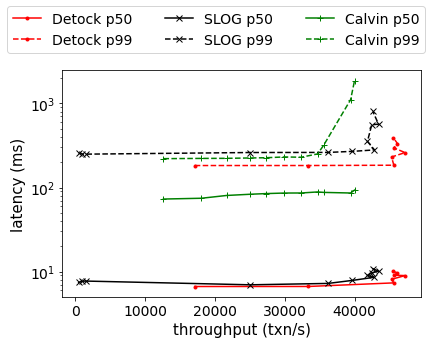

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
config_names = ["ddr_ts.conf", "baseline.conf", "calvin.conf"]
config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (without Opportunistic Ordering)',
    'ddr_ts.conf': 'Detock',
    'calvin.conf': 'Calvin',
}

ax.set_prop_cycle((cycler(marker=['.', 'x', '+']) + cycler(color='rkg')) * cycler(linestyle=['-', '--']))

for config in config_names:
    label = config_to_label[config]
    throughput_latency_df[throughput_latency_df.config_name == config].plot(x="throughput", y="percentile_50", label=f"{label} p50", ax=ax, legend=False)
    throughput_latency_df[throughput_latency_df.config_name == config].plot(x="throughput", y="percentile_99", label=f"{label} p99", ax=ax, legend=False)

ax.set_yscale('log')
ax.set_ylabel("latency (ms)")
ax.set_xlabel("throughput (txn/s)")
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=3)
fig.tight_layout()
fig.savefig('output/tpcc-throughput-latency.pdf', bbox_inches='tight')
fig.savefig('output/tpcc-throughput-latency.png', bbox_inches='tight')